In [ ]:
# default_exp time_series
%reload_ext autoreload
%autoreload 2
from nbdev import *
from utilities.ipynb_docgen import *

# Periodograms

> This code treats a set of cells as a time series, and applies FFT, creating a "periodogram" meassure of the frequency content.

It is based on the development in [Kerr](https://arxiv.org/pdf/1910.00140.pdf) Section 5 equations (6) and (8), using code from the [godot](https://github.com/kerrm/godot) implementation, specifically the function `power_spectrum_fft` which follows.

In [ ]:
# export
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wtlike.config import *
from wtlike.cell_data import CellData
from wtlike.exposure import cell_exposure
from wtlike.simulation import Simulation

In [ ]:
# exporti
def make_time_cells(self, time_bins):
    """Return a dict of time-sample cells with moments of the weights

    -- self : an object with config, exposure, photons
    -- time_bins : a 3-tuple  (start, stop, delta), which may be (0,0,delta) for full range
    """
    # get data, exposure and photons from self
    config   = getattr(self, 'config', None) or Config()
    exposure = self.exposure
    photons  = self.photons

    # process exposure
    expdict =  cell_exposure(config,  exposure, time_bins)
    cell_edges = expdict['edges']
    tspan = cell_edges[-1]-cell_edges[0]
    tsamp = time_bins[2]

    cell_exp   = expdict['exp']
    etot = expdict['etot'] #sum(cell_exp)

    # get the estimates from the full dataset for signal and background counts/exposure
    S = sum(photons.weight)
    B = len(photons)-S
    Sk,Bk = S/etot, B/etot

    # use photon times to get cell index range into photon list
    photon_cell = np.searchsorted(photons.time, cell_edges).reshape(len(cell_edges)//2,2)
    wts = photons.weight.values.astype(np.float32)
    weight_cell = [wts[slice(*cell)] for cell in photon_cell]

    # this is the list of attributes (plus tstart)  needed for the "timeseries" object to be passed to power_spectrum_fft
    return  dict(
        counts = np.array( [len(w)   for w in weight_cell], np.int32),
        weights= np.array( [sum(w)   for w in weight_cell], np.float32),
        weights2=np.array( [sum(w*w) for w in weight_cell], np.float32),
        sexp   = cell_exp * Sk,
        bexp   = cell_exp * Bk,
        tstart = cell_edges[0],
        tspan = tspan,
        tsamp = tsamp,
        f_Nyquist = 1/tsamp/4,
        )

In [ ]:
# export
def power_spectrum_fft(timeseries,dfgoal=None,tweak_exp=False,
        exp_only=False,get_amps=False,exposure_correction=None,
                      minf=0,):
    """ Use FFT to evalute the sums in the maximum likelihood expression.

    This version matches the notation in the paper.

    tweak_exp -- make sure that the mean signal for source and background
        are 0; helps prevent spectral leakage from low frequencies

    get_amps -- if True, return frequencies, real amplitudes, imag.
        amplitudes, and their uncertainties.  (NB these are the
        *fractional* modulation coefficients.)

    Returns: frequencies, P_0 (background fixed power spectrum),
        P_1 (background-free spectrum), P_b (power spectrum of background)

    NB that the resulting power spectrum is oversampled, at least to the
    nearest convenient power of 2, and of course there are gaps in the
    LAT exposure.  Therefore the oversampling can be e.g. >5x.  Thus care
    is needed if examining the distribution of the PSD, e.g. with a KS
    test, the effective sqrt(N) is smaller than otherwise might seem.

    THB:
    * add `minf`,default 0, to set lowest frequency to return. If set to one, avoid runtime warnings
       at zero frequency

    """


    cells = timeseries

    W = cells.weights
    WW = cells.weights2
    S = cells.sexp
    if exposure_correction is not None:
        S = S * exposure_correction
    if tweak_exp:
        S = S*W.sum()/S.sum()
    Wb = cells.counts-W # \bar{W}
    WbWb = cells.counts-2*W+WW
    B = cells.bexp
    if tweak_exp:
        B = B*Wb.sum()/B.sum()

    if exp_only:
        # this will cause the primary FFT to be of the exposure (with mean
        # subtracted to avoid spectral leakage).  The other estimators will be
        # garbage.
        W = 2*S-S.mean()


    # come up with a nice power of 2 for doing the FFT portion
    # THB: this is "zero-padding" to increase resolution
    if dfgoal is None:
        dfgoal = 0.2/cells.tspan
    nfft = 1./(cells.tsamp * dfgoal)
    l = 2**(int(np.log2(nfft))+1)
    zeros = np.zeros(l-len(W))

    # zero pad
    W = np.append(W,zeros)
    WW = np.append(WW,zeros)
    S = np.append(S,zeros)
    Wb = np.append(Wb,zeros)
    WbWb = np.append(WbWb,zeros)
    B = np.append(B,zeros)


    freqs = np.fft.rfftfreq(l)/cells.tsamp # ()

    # now use FFT to evaluate the various cosine moments, for the
    # maximum likelihood estimators
    ### THB mod to put duplicated code invoking FFT into local functions
    def fft0(Z):
        f = np.fft.rfft(Z)[minf:(l//4+1)]
        return np.real(f), np.imag(f)
    def fft1(W):
        f = np.fft.rfft(W)
        S2 = f[0].real
        return 0.5*(S2+np.real(f)[2*minf::2]), 0.5*(S2-np.real(f)[2*minf::2])

    WmS_cos,  WmS_sin  = fft0(W-S)
    WbmB_cos, WbmB_sin = fft0(Wb-B)
    WW_cos,   WW_sin   = fft1(WW)
    WbWb_cos, WbWb_sin = fft1(WbWb)
    WWb_cos,  WWb_sin  = fft1(W-WW)

    # form non-coupled estimators first
    alpha_cos0 = WmS_cos/WW_cos
    alpha_sin0 = WmS_sin/WW_sin
    beta_cos0  = WbmB_cos/WbWb_cos
    beta_sin0  = WbmB_sin/WbWb_sin

    # coupled estimators
    denom_cos = 1./(WW_cos*WbWb_cos-WWb_cos**2)
    denom_sin = 1./(WW_sin*WbWb_sin-WWb_sin**2)
    alpha_cos = (WbWb_cos*WmS_cos-WWb_cos*WbmB_cos)*denom_cos
    alpha_sin = (WbWb_sin*WmS_sin-WWb_sin*WbmB_sin)*denom_sin
    beta_cos  = (WW_cos*WbmB_cos-WWb_cos*WmS_cos)*denom_cos
    beta_sin  = (WW_sin*WbmB_sin-WWb_sin*WmS_sin)*denom_sin

    if get_amps:
        return freqs[minf:(l//4+1)],alpha_cos0,alpha_sin0,WW_cos,WW_sin

    # for all estimators, the second order correction simply removes half
    # of the value, so that multiplying by 2 gets you back to Leahy.  So
    # let's just stick with the first order!

    # this is the case for non-varying source (alpha(t)=0)
    dlogl_null = beta_cos0*WbmB_cos + beta_sin0*WbmB_sin
    # this is the case for non-varying background (beta(t)=0; P_0 in the paper)
    dlogl_nobg = alpha_cos0*WmS_cos + alpha_sin0*WmS_sin
    # this is the profile likelihood test statistic  (P_s + P_b in the paper)
    dlogl  = alpha_cos*WmS_cos + alpha_sin*WmS_sin + beta_cos*WbmB_cos + beta_sin*WbmB_sin
    if exp_only:
        return freqs[minf:(l//4+1)],dlogl_nobg

    return freqs[minf:(l//4+1)], dlogl_nobg, dlogl-dlogl_null, dlogl_null

In [ ]:
#export
def power_spectrum_plot(power_df,  pmax=None, profile=True,  ax=None, name=None,
               fs=() ,**kwargs):
    """ Make a plot like Kerr Fig 6

    - power_df -- a DataFrame with 4 columns corresponding to output from power_spectrum_fft
    = pmax -- if set, the maximum power
    - profile [True] -- make False to show P0 instead of P1

    - kwargs -- passed to the Axes object
    """
    import matplotlib.ticker as ticker

    df = power_df
    pmax = pmax or max(df.p1.max(), df.pb.max())* 1.1

    # default kwarg values
    kw = dict(xlim=(0,None),
              ylim=(-pmax, pmax),
              xlabel=r'$\mathrm{Frequency\ (cycles\ d^{-1})}$',
              ylabel=r'$\leftarrow P_b \ \ \ \ P_1 \rightarrow $' if profile else \
                      r'$\leftarrow P_b \ \ \ \ P_0 \rightarrow $',)
    kw.update(kwargs)

    fig, ax = plt.subplots(figsize=(8,4)) if ax is None else (ax.figure, ax)

    ax.plot(df.f,  df.p1 if profile else df.p0, '-', color='cornflowerblue', lw=2)
    ax.plot(df.f, -df.pb, '-', color='orange', lw=2)

    ax.axhline(0, color='grey')
    ax.set( **kw)
    # y-axis: no display abs to account for negatives
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,p: f'{abs(x):.0f}' ))
    # x-axis: pretty if log scale
    if kw.get('xscale',None)=='log': ax.xaxis.set_major_formatter(
          lambda val,pos: { 0.001:'0.001', 0.01:'0.01', 0.1:'0.1', 1.0:'1', 10.0:'10',}.get(val,''))
    ax.grid(alpha=0.5)

    if name is not None:
        ax.text(0.02,0.96,  name, va='top', transform=ax.transAxes)

    ap = dict(arrowstyle='->',color='k', lw=3)

    for f in fs:
        ax.annotate('', xy=(f, 0.85*pmax), xytext=(f, pmax),# transform=ax.transData,
                    arrowprops=ap);
        ax.annotate('', xy=(f, -0.85*pmax), xytext=(f, -pmax),# transform=ax.transData,
                    arrowprops=ap);

In [ ]:
# export
class PeakFinder(pd.DataFrame):
    """ Manage a lot of the positions of peaks in smooth distribution
    """
    @property
    def _constructor(self):
        return PeakFinder

    def __init__(self, *pars):
        """estimate positions of peaks in a smooth function sampled at (x,y) pairs
        assume x array is equally spaced.
        """
        if len(pars)<2:
            # can happen if query called.
            super().__init__(*pars)
        else:
            x,y = pars
            # get gradient
            g = np.gradient(y)

            # index of first point before peak, where gradient changes sign
            qp = (g[:-1]>0) & (g[1:]<0)
            qi = np.arange(len(g)-1)[qp]

            # find peaks, interpolating the gradient to zero
            g1,g2 = g[qi],g[qi+1]
            xp = x[qi] + g1/(g1-g2)*(x[1]-x[0])

            # estimate peak value with largest of two points
            yp = np.max(np.vstack([y[qi],y[qi+1]]),axis=0)

            # set up the class instance
            super().__init__(dict(x=xp, y=yp))
            self.deltax = x[1]-x[0]
            self.num   = len(x)
            self.xmin, self.xmax  = x[0], x[-1]

    def find_closest(self, x):
        """return the index of the closest entry to x
        """
        # allows renaming of first col
        t = np.abs(self.iloc[:,0] -x)
        return np.where(t==t.min())[0][0]

,x,y
2,2.249889,0.974928


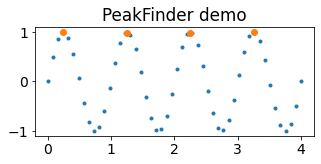

In [ ]:
# collapse-hide
x = np.linspace(0, 4)
y = np.sin(x*2*np.pi)
dfp = PeakFinder(x,y)
plt.figure(figsize=(5,2))
plt.title('PeakFinder demo')
plt.plot(x,y, '.')
plt.plot(dfp.x,dfp.y, 'o');


dfp.find_closest(2.5)
dfp.query('2<x<3')

In [ ]:
# export

class Spectogram(pd.DataFrame):
    """Create a spectogram as a DataFrame

    columns correspond to frequencies, and rows to time intervals.

    Parameters
    * power ['p0'] or p1 or pb
    * interval [10] -- time interval (days)
    * overlap [1]   -- overlap
    * tsamp [1/24]  -- sampling rate  (1/days)


    """
    @property
    def _constructor(self): #, *pars, **kwargs):
        return Spectogram #(*pars, **kwargs)

    def __init__(self,  *pars, **kwargs): # power='p0', interval=10, overlap=1, tsamp=1/24):

        if len(pars)!=1 or not isinstance(pars[0], TimeSeries):
            # this constructor only for a TimeSeries parameter
            super().__init__(*pars, **kwargs)
        else:
            ts = pars[0]
            kw = dict(power='p0', interval=10, overlap=1, tsamp=1/24)
            kw.update(**kwargs)
            self.__dict__.update(**kw)
            assert self.power in ('pb', 'p0', 'p1'), 'Power must be one of p0 p1 pb'

            # create the frequency x time table
            pmaps= []
            a = tstart = ts.tstart
            b = a+self.interval*self.overlap
            tstop = a + ts.tspan
            while b<= tstop: #  a,b in #FermiInterval(self.interval):
                ts.setup_cells(a, b, self.tsamp)
                f = ts.power_df.f.values
                pmaps.append(ts.power_df[self.power].values)
                a,b = a+self.interval, b+self.interval
            sgdata = np.vstack(pmaps)

            # make the row index and column index lists
            ny,nx = sgdata.shape
            columns = np.linspace(f[0], f[-1], nx)
            deltat = (tstop-tstart)/ny
            index = np.linspace(tstart, tstop-deltat, ny) + deltat/2

            # restore the TimeSeries object's cells
            ts.setup_cells(tstart, tstop, self.tsamp)
            # then make the DataFrame
            super().__init__(sgdata, columns=columns, index=index)

    def __str__(self):
        return 'Spectrogram:\n' + super().__str__()

    def sgplot(self, ax=None, imshow_kw={}, grid='',  **kwargs):
        """ Makes 2-d spectrogram display
        """

        fig, ax = plt.subplots(figsize=(10,8)) if ax is None else (ax.figure, ax)
        dx = self.columns[-1]-self.columns[0]
        dy = self.index[-1]-self.index[0]
        imkw= dict(cmap='jet',vmin=5, vmax=25, origin='lower',
                   aspect=dx/dy,)
        imkw.update(imshow_kw)
        def get_extent(a):
            d = (a[1]-a[0])/2
            return a[0]-d, a[-1]+d
        ax.imshow(self.to_numpy(), extent= get_extent(self.columns)+get_extent(self.index) ,
                  **imkw);
        if grid: ax.grid(color=grid);
        kw = dict(ylabel='Time (MJD)', xlabel='Frequency (cycles $\mathrm{d^{-1})}$',)
        kw.update(kwargs)
        ax.set(**kw)

In [ ]:
#export
class TimeSeries():
    """
    Generate a special set of cells for Fourier analysis
    Object of this class can be passed to godot/core.power_spectrum_fft, an (almost) copy
    of which is here.

    - source -- name of a source, an object inheriting from CellData, or a Simulation object
    - tsamp  -- time sample size (in days)
    - rfact  -- resolution factor [5]
    """

    def __init__(self, source, config=None, tsamp=1/24, rfact=5):

        self.config = config or Config()
        self.tsamp = tsamp
        self.rfact = rfact

        tbins = (0,0,tsamp)
        if type(source)==str:
            ## string: create a CellData with binning
            self.cd = CellData(source, config=config, time_bins=tbins)
        elif isinstance(source, CellData) : #, 'Expected a CellData object'
            # existing CellData instance: make new rebined view without refitting
            self.cd = source.view(0,0,tsamp, no_update=True)
        elif isinstance(source,Simulation):
            self.cd = source
        else:
            raise Exception('Expected a source name, or a CellData or Simulation object')

        self.setup_cells(0,0,tsamp)

    def setup_cells(self, *pars, **kwargs):
        """
        """
        self.cell_dict  = make_time_cells(self.cd, pars)
        self.__dict__.update(self.cell_dict)
        # always set the power spectrum
        self.power_df = self.power_spectrum()
        self.fft_factor = 4*len(self.power_df)/len(self.weights)

    def __repr__(self):
        n = len(self.counts)
        return f'TimeSeries: {n} cells for MJD {self.tstart}-{self.tstart+self.tspan},FFT factor {self.fft_factor:.1f}'


    @property
    def cells(self):
        """return a DataFrame of the cells as a property
        """
        return pd.DataFrame(dict( [(k, getattr(self,k) ) for k in 'counts weights weights2 sexp bexp'.split()]))

    def power_spectrum(self, **kwargs):
        """
        Invoke the godot/core routine `power_spectrum_fft` to generate a periodogram DataFrame

        kwargs passed to power_spectrum_fft
         - tweak_exp [True]
         - dfgoal=None,
         - exp_only=False
         - get_amps=False
         - exposure_correction=None
        """
        if self.config.verbose>1:
            print(f'TimeSeries: making periodogram with, {int(self.tspan/self.tsamp):,d} samples, '
                  f'size {self.tsamp*24:.2f} h: Nyquist is {self.f_Nyquist} /d')

        kw = dict(tweak_exp=True, dfgoal=1/self.rfact/self.tspan, minf=1)
        kw.update(kwargs)

        # invoke copy of Kerr's godot/core.power_spectru_fft
        # return exposure spectrum, or P0,P1, and Pb
        if kwargs.get('exp_only', False):
            f, p0 = power_spectrum_fft(self, **kw)
            return pd.DataFrame.from_dict(dict(
                f = f.astype(np.float32),
                p_exp = p0.astype(np.float32)))

        f, p0, p1, pb = power_spectrum_fft(self, **kw)
        self.power_df = pd.DataFrame.from_dict(dict(
            f  = f.astype(np.float32),
            p0 = p0.astype(np.float32),
            p1 = p1.astype(np.float32),
            pb = pb.astype(np.float32),
            ))
        return self.power_df

    def amplitudes(self, **kwargs):
        """
        Invoke the godot/core routine `power_spectrum_fft` to generate the amplitude DataFrame


        """
        if self.config.verbose>0:
            print('TimeSeries: creating amplitude spectra')
        kw = dict(tweak_exp=True, get_amps=True, minf=1)
        kw.update(kwargs)

        f, a,b,c,d = power_spectrum_fft(self, **kw)
        self.amplitude_df = pd.DataFrame.from_dict(dict(
            f  = f.astype(np.float32),
            acos = a.astype(np.float32),
            asin = b.astype(np.float32),
            ucos = c.astype(np.float32),
            usin = d.astype(np.float32),
            ))

    def phase_df(self, diff=True, offset=0):
        """ Return a phase dataframe
        """
        if not hasattr(self, 'amplitude_df'):
            self.amplitudes()
        adf = self.amplitude_df.copy()
        adf.loc[:,'phi'] = np.arctan2(adf.acos, adf.asin)
        if not diff:
            return adf
        #delphi = np.mod(np.diff(adf.phi)-offset, np.pi)
        delphi = np.diff(adf.phi)-offset
        delphi[delphi<-np.pi] += 2*np.pi
        f = 0.5*(adf.f.values[1:]+adf.f.values[:-1])
        return pd.DataFrame(dict(f=f, delphi=delphi))

    def find_peaks(self, power='p0'):
        """
        Determine positions and values of the peaks in the given power spectrum

        - power: Select p0, p1, or pb

        return a DataFrame with columns f and p for the frequencies and power values
        """
        df = self.power_spectrum()
        expect = 'p0 p1 pb'.split()
        assert power in expect, f'TimeSeries.find_peaks: {power} not one of expected {expect}'
        y = df[power].values
        x = df.f.values

        pkdf = PeakFinder(x,y)
        return pkdf.rename(columns=dict(x='f', y=power))

    def power_plot(self,  pmax=None, profile=True,  ax=None, name=None,
                   fs=() ,**kwargs):

        """ Make a plot like Kerr Fig 6

        = pmax -- if set, the maximum power
        - profile [True] -- make False to show P0 instead of P1

        - kwargs -- passed to the Axes object
        """

        import matplotlib.ticker as ticker

        df = self.power_spectrum()

        power_spectrum_plot(df, pmax=pmax, profile=profile, ax=ax, name=name, fs=fs, **kwargs)

    def spectogram(self, ax=None, interval=10, overlap=1, tsamp=1/24,
               imshow_kw={},  **kwargs):
        """Return a Spectrogram object
        """
        return Spectogram(self, ax=ax, interval=interval, overlap=overlap, tsamp=tsamp)
#         from wtlike.config import FermiInterval, MJD

#         pmaps= []
#         tnow = MJD('now')
#         for r in FermiInterval(interval):
#             stop= r[0] + overlap*interval # overlap
#             if stop > tnow: break
#             self.setup_cells(r[0], stop, tsamp)
#             f = self.power_df.f.values
#             pmaps.append(self.power_df.p1.values)

#         z = np.vstack(pmaps)
#         extent=( f[0], f[-1], first_data, tnow,)

#         fig, ax = plt.subplots(figsize=(10,8)) if ax is None else (ax.figure, ax)
#         imkw= dict(cmap='jet',vmin=5, vmax=25, origin='lower', aspect=1/1500,)
#         imkw.update(imshow_kw)
#         ax.imshow(z, extent=extent,**imkw);
#         ax.grid(color='lightgrey');
#         kw = dict(ylabel='Time (MJD)', xlabel='Frequency (cycles $d^{-1})$',)
#         kw.update(kwargs)
#         ax.set(**kw)

In [ ]:
# export
class Sinc():
    """ A functor for the function sinc(x)**2.
    """
    def __init__(self, A, freq, delf):
        """
        * A amplitude
        * freq frequency
        * delf -- frequency delta = 1/T
        """
        self.A, self.freq, self.delf = A,freq, delf
        self.sincsq =  lambda x: A*np.sinc((x-freq)/delf)**2

    def __call__(self, x):
        return self.sincsq(x)

    def lim(self, f=2):
        return  (self.freq-f*self.delf, self.freq+f*self.delf)

    def plot(self, width=2, ax=None, pticks=None, **kwargs):
        """Make a power vs. frequency plot

        - xlim : tuple(fmin,fmax) | None -- plot xlim. If None, center on peak,
                range 6x width
        - pticks : if specified, ticks for upper period scale
        """
        xlim = self.lim(width)
        x = np.linspace(*xlim)
        fig, ax = plt.subplots(figsize=(4,3)) if ax is None else (ax.figure, ax)
        label = kwargs.pop('label', '')
        ax.plot(x, self.sincsq(x),'-', label=label)
        toplabel = kwargs.pop('toplabel', 'Period')
        ax.set(xlim=xlim, **kwargs)
        ax.grid(0.5)

        if pticks is None: return
        a,b = np.array(xlim)
        x2 = lambda p: (1/p-a)/(b-a)
        ax.twiny().set(xlabel=toplabel, #'Period',
                xticks=x2(np.array(pticks)),
                xticklabels=[ f'{t}' for t in pticks])

In [ ]:
show_doc(Sinc)
show_doc(Sinc.plot)

<h2 id="Sinc" class="doc_header"><code>class</code> <code>Sinc</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>Sinc</code>(**`A`**, **`freq`**, **`delf`**)

A functor for the function sinc(x)**2.
    

<h4 id="Sinc.plot" class="doc_header"><code>Sinc.plot</code><a href="__main__.py#L20" class="source_link" style="float:right">[source]</a></h4>

> <code>Sinc.plot</code>(**`width`**=*`2`*, **`ax`**=*`None`*, **`pticks`**=*`None`*, **\*\*`kwargs`**)

Make a power vs. frequency plot

- xlim : tuple(fmin,fmax) | None -- plot xlim. If None, center on peak,
        range 6x width
- pticks : if specified, ticks for upper period scale

### Sinc class demo

<figure style="margin-left: 5%" title="Figure 1">   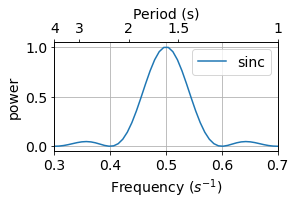 </figure>


In [ ]:
# collapse-hide
@ipynb_doc
def sinc_demo():
    """
    ### Sinc class demo
    
    {fig}
    """
    fig, ax = plt.subplots(figsize=(4,2))
    ax.set(xlabel='Frequency ($s^{-1}$)', ylabel='power')
    sinc = Sinc(1, 0.5, 0.1)
    sinc.plot(ax=ax, pticks=[1,1.5,2,3,4], label='sinc', toplabel='Period (s)')
    ax.legend()
    return locals()

sinc_demo()

In [ ]:

show_doc(TimeSeries)

<h2 id="TimeSeries" class="doc_header"><code>class</code> <code>TimeSeries</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>TimeSeries</code>(**`source`**, **`config`**=*`None`*, **`tsamp`**=*`0.041666666666666664`*, **`rfact`**=*`5`*)

Generate a special set of cells for Fourier analysis
Object of this class can be passed to godot/core.power_spectrum_fft, an (almost) copy
of which is here.

- source -- name of a source, an object inheriting from CellData, or a Simulation object 
- tsamp  -- time sample size (in days)
- rfact  -- resolution factor [5]

## Simulation Test 
<details  class="nbdoc-description" >  <summary> Output during setup </summary>  <div style="margin-left: 5%;"><pre>generated 25902 photons<br></pre></div> </details>

### Simulation/FFT details:

* Duration $T=50\ d$,  
* Sample rate $24\ d^{-1}$ 
* Signal: $S(t) = 10^{-6}\ \big[1 + A \cos(2\pi f_S t)\big]$, where $f_S$ is the source 
  frequency 5.0, and the amplitude $A=0.1$. 
* Background: fixed at $10^{-6}$.
* FFT: 1200 samples zero-padded to 8192, factor 6.8

### The periodogram
<figure style="margin-left: 5%" title="Figure 1">   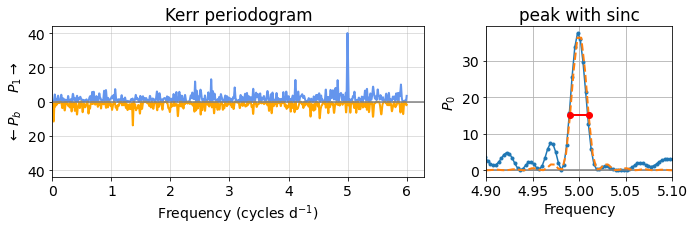  <figcaption><b>Figure 1</b>. Left plot: The full Kerr periodogram showing $P_B$ and $P_1$ up to the Nyquist frequency 6.0.
        Right plot: The $P_0$ spectral measure overlaid with the sinc function at the frequency $f_S$
        adjusted to match the peak and with its expected width, $1/T=0.02$. (Note that the FFT processing uses
        zero padding by at least a factor of 5 to improve the FFT resolution.)</figcaption></figure>

### Peak detection

Peak finding finds 189 peaks.
The nearest peak to the expected signal:
<br><div style="margin-left: 5%;"><pre>f      4.998702<br>p0    37.552967<br>Name: 158, dtype: float32</pre></div>

<figure style="margin-left: 5%" title="Figure 2">   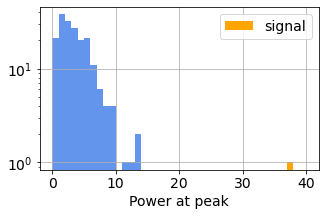  <figcaption><b>Figure 2</b>. Distribution of peak power values</figcaption></figure>


In [ ]:
# collapse-hide
cd = None # the TimeSeries object for manipulation below
@ipynb_doc
def sim_test(amp=1, freq=5, T=50, srate=24, rng=None):
    r"""
    ## Simulation Test 
    {setup_txt}
    
    ### Simulation/FFT details:
    
    * Duration $T={T}\ d$,  
    * Sample rate ${srate}\ d^{-1}$ 
    * Signal: $S(t) = 10^{-6}\ \big[1 + A \cos(2\pi f_S t)\big]$, where $f_S$ is the source 
      frequency {freq:.1f}, and the amplitude $A={amp}$. 
    * Background: fixed at $10^{-6}$.
    * FFT: {nsamp} samples zero-padded to {nsize}, factor {resf:.1f}
    
    ### The periodogram
    {fig1}
    
    ### Peak detection
    
    Peak finding finds {nump} peaks.
    The nearest peak to the expected signal:
    <br>{signal_text}
    
    {fig2}
    """
    global cd
    from wtlike.simulation import Simulation
    def periodic(t):
        return 1e-6 * ( 1+ amp*np.cos(2*np.pi*freq*t) )
    tsamp = 1/srate
    with capture_hide('Output during setup') as setup_txt:
        sim = Simulation('periodic', src_flux=periodic, tstart=0, tstop=T, rng=rng)
        sim.run()
        cd = TimeSeries(sim, tsamp=tsamp, )
    
    sim_info = cd.__repr__()
    delf = 1/T # window resolution
    fnyquist = 0.25/cd.tsamp
    nsamp = int(T/cd.tsamp)
    nsize = 4*len(cd.power_df)
    resf  = delf/cd.power_df.f[0]
    
    def left(ax):
        cd.power_plot(ax = ax, title='Kerr periodogram');    #fig, ax = plt.subplots(figsize=(8,4))
    
    def right(ax):        
        ax.plot(cd.power_df.f, cd.power_df.p0, '.-');
        ax.grid(True)
        ax.axhline(0, color='grey')
        xlim = (freq-5*delf,freq+5*delf)
        ax.set(xlim =xlim, 
               xlabel='Frequency', ylabel='$P_0$',title='peak with sinc');
        A, m,b = cd.power_df.p0.max(), freq,  delf
        sincsq = lambda x: A*np.sinc((x-m)/b)**2 
        x = np.linspace(*xlim)
        ax.plot(x, sincsq(x), '--', lw=2 );
        hh = np.array([freq-delf/2, freq+delf/2])
        ax.plot(hh, sincsq(hh),'o-r', lw=2);
        
    fig1 = figure(plt.figure(figsize=(12,3)), 
        caption=f"""Left plot: The full Kerr periodogram showing $P_B$ and $P_1$ up to the Nyquist frequency {fnyquist}.
        Right plot: The $P_0$ spectral measure overlaid with the sinc function at the frequency $f_S$
        adjusted to match the peak and with its expected width, $1/T={delf}$. (Note that the FFT processing uses
        zero padding by at least a factor of 5 to improve the FFT resolution.)""",
        width = 800)
    plt.subplots_adjust(wspace=0)
    gs = plt.GridSpec(1,10)

    left(  fig1.add_subplot(gs[:6]) )
    right( fig1.add_subplot(gs[7:]) )
    
    # find the peak
    peak_df = cd.find_peaks()
    nump = len(peak_df)
    
    k = peak_df.find_closest(freq)
    signal = peak_df.iloc[k] #peak_df.query(f'{freq-1/T}<x<{freq+1/T}')
    signal_text = monospace(str(signal))
    
    def peak_plot(fig):
        y = cd.power_df.p0.values
        x = cd.power_df.f.values
        xp, yp = peak_df.iloc[:,0], peak_df.iloc[:,1]
        
        ax = fig.add_subplot()
        hkw = dict(bins=np.linspace(0,40,41), histtype='stepfilled', log=True)
        ax.hist(yp, color='cornflowerblue', **hkw);
        ax.hist(signal.p0, label='signal', color='orange', **hkw);
        ax.set(xlabel='Power at peak')
        ax.legend()
        ax.grid(True)
        
            
    fig2 =  figure(plt.figure(figsize=(5,3)), 
                     caption='Distribution of peak power values')
    peak_plot(fig2)
    return locals()
# need to bix
sim_test(amp=0.1, fignum=1, rng=24)

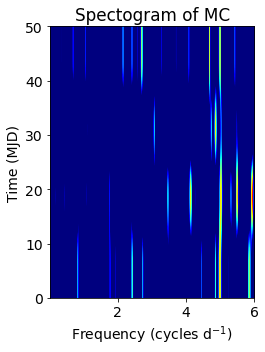

In [ ]:
# hide
sg =cd.spectogram(interval=12.5)
fig, ax = plt.subplots(figsize=(5,5))
sg.sgplot(ax=ax, imshow_kw=dict(vmax=None), title='Spectogram of MC')

TimeSeries: creating amplitude spectra


## Look at the phase

The plot below is of the differences of the phase measured in sequential frequencies, using the analysis above.
Subtracted from that is a constant offset, 0.46 radians. This is $\pi$ divided by the FFT zero-padding factor 6.83.
<figure style="margin-left: 5%" title="Figure 1">   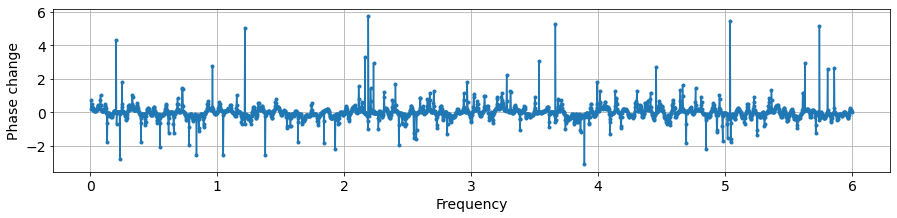 </figure>

Here is a histogram of the phase differences.
<figure style="margin-left: 5%" title="Figure 2">   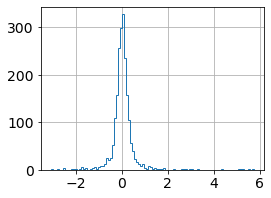 </figure>

Note that the periodic signal is not evident in the phase information--no visible change at its frequency.


In [ ]:
# collapse-hide
@ipynb_doc
def sim_phase():
    """ 
    ## Look at the phase
    
    The plot below is of the differences of the phase measured in sequential frequencies, using the analysis above.
    Subtracted from that is a constant offset, {offset:.2f} radians. This is $\pi$ divided by the FFT zero-padding factor {fftf:.2f}.
    {fig1}
    
    Here is a histogram of the phase differences.
    {fig2}
    
    Note that the periodic signal is not evident in the phase information--no visible change at its frequency.
    """
    self = cd
    fftf = cd.fft_factor
    offset = np.pi/cd.fft_factor
    dfx = cd.phase_df(offset=offset) 
    fig2, ax = plt.subplots(figsize=(4,3))
    ax.hist(dfx.delphi, 100, log=False, histtype='step');
    ax.grid();
    
    fig1, ax1 = plt.subplots(figsize=(15,3))
    ax1.plot(dfx.f, dfx.delphi, '.-');
    ax1.set(xlabel='Frequency', ylabel='Phase change')
    ax1.grid();#plt.xlim(4.8, 5.2);
    
    
    return locals()
sim_phase()

## Output spectra using `wtlike.TimeSeries`


<details  class="nbdoc-description" >  <summary> Source setup output </summary>  <div style="margin-left: 5%;"><pre>SourceData:  PSR J0835-4510: Restoring from cache with key "PSR J0835-4510_data"<br>SourceData: Source Vela pulsar with:<br>	 data:     3,587,233 photons from 2008-08-04 to 2022-05-26<br>	 exposure: 3,269,606 intervals,  average effective area 3460 cm^2 for 97.7 Ms<br>	 rates:  source 8.56e-06/s, background 2.05e-06/s, TS 7052015.5<br>CellData.rebin: Bin photon data into 484032 15-min bins from 54683.0 to 59725.0<br>SourceData:  4FGL J0633.9+1746: Restoring from cache with key "PSR J0633+1746_data"<br>SourceData: Source Geminga with:<br>	 data:     1,197,397 photons from 2008-08-04 to 2022-05-26<br>	 exposure: 3,357,973 intervals,  average effective area 2698 cm^2 for 100.4 Ms<br>	 rates:  source 3.31e-06/s, background 1.11e-06/s, TS 2290923.9<br>CellData.rebin: Bin photon data into 484032 15-min bins from 54683.0 to 59725.0<br>SourceData:  LS 5039: Restoring from cache with key "P88Y5020_data"<br>SourceData: Source LS 5039 with:<br>	 data:     1,699,846 photons from 2008-08-04 to 2022-05-26<br>	 exposure: 3,186,410 intervals,  average effective area 2940 cm^2 for 95.1 Ms<br>	 rates:  source 2.90e-07/s, background 5.79e-06/s, TS 8946.5<br>CellData.rebin: Bin photon data into 484032 15-min bins from 54683.0 to 59725.0<br>SourceData:  Cygnus X-3: Restoring from cache with key "504H-0317_data"<br>SourceData: Source Cygnus X-3 with:<br>	 data:     1,672,484 photons from 2008-08-04 to 2022-05-26<br>	 exposure: 3,584,619 intervals,  average effective area 3330 cm^2 for 107.2 Ms<br>	 rates:  source 3.72e-08/s, background 4.65e-06/s, TS 462.3<br>CellData.rebin: Bin photon data into 484032 15-min bins from 54683.0 to 59725.0<br></pre></div> </details>

This analysis uses a time bin size of 0.25 h for a Nyquist frequency of 24  $d^{-1}$
and a total interval of 5042 d. 
<figure style="margin-left: 5%" title="Figure 1">   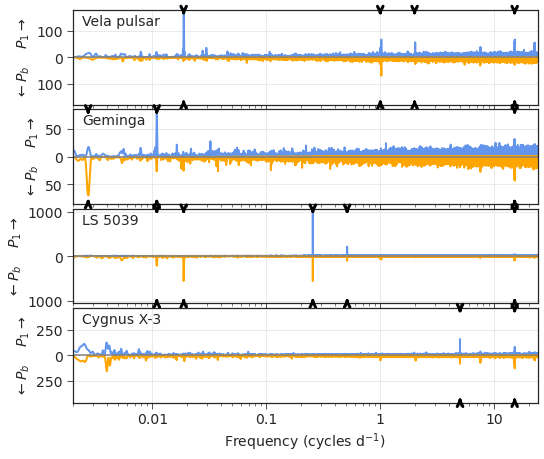 </figure>

<details open class="nbdoc-description" >  <summary> The tagged frequencies </summary>  <div style="margin-left: 5%;"><pre>   frequency  period                  comment<br>0      0.003  365.25                   1/year<br>1      0.011   91.31                   4/year<br>2      0.019   53.05         Fermi precession<br>3      0.256    3.91   LS 5039 orbital period<br>4      0.512    1.95         LS 5039 harmonic<br>5      1.003    1.00             sidereal day<br>6      5.010    0.20   Cyg X-3 orbital period<br>7     15.100    0.07  Fermi orbital frequency<br></pre></div> </details>
This set of plots show the results of analyses of the three sources that Matthew examined, plus Vela.
Like Kerr's Figure 6, the upper blue plot for each source is the profile likelihood estimator $P_1$, 
and the bottom orange plot the background-fixed estimator $P_b$. 

### Exposure power spectrum
It is also possible to extract only the exposure spectrum

<figure style="margin-left: 5%" title="Figure 2">   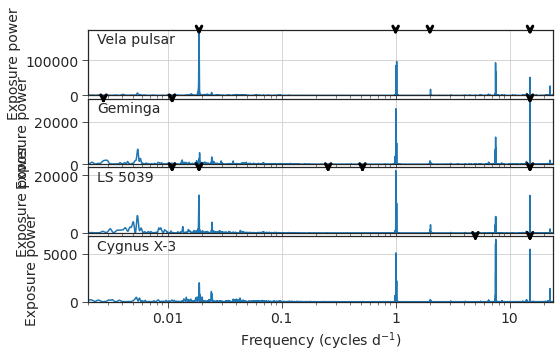 </figure>


In [ ]:
# collapse-hide
tms_list=[]
@ipynb_doc
def source_ffts(source_list, fs_list, xlim=None, xscale='log'):
    """
    ## Output spectra using `wtlike.TimeSeries`


    {txt}
    
    This analysis uses a time bin size of {tbin_h:.2f} h for a Nyquist frequency of {nyquist:.0f}  $d^{-1}$
    and a total interval of {tspan:.0f} d. 
    {fig1}

    {txt2}
    This set of plots show the results of analyses of the three sources that Matthew examined, plus Vela.
    Like Kerr's Figure 6, the upper blue plot for each source is the profile likelihood estimator $P_1$, 
    and the bottom orange plot the background-fixed estimator $P_b$. 
    
    ### Exposure power spectrum
    It is also possible to extract only the exposure spectrum
    
    {fig2x}
    """
    global tms_list
    plt.style.use('seaborn-ticks')
    tbinsize=1/96; tbin_h = tbinsize*24
    with capture_hide(f'Source setup output') as txt:        
        tms_list = [TimeSeries(name, tsamp=tbinsize) for name in source_list]

    nyquist = tms_list[0].f_Nyquist
    tspan = tms_list[0].tspan
    N = len(source_list)    
    
    fig, axx = plt.subplots(N,1, figsize=(15,3*N+1), sharex=True,)
    plt.subplots_adjust(hspace=0.05)
    fig1 = figure(fig, width=600)
    
    for name, ax, fs,tms in zip(source_list, axx.flatten(), fs_list, tms_list):
        tms.power_spectrum(minf=1)
        tms.power_plot(ax=ax, xlim=xlim or (2e-3,nyquist), 
                       pmax=None, xscale=xscale, fs=fs, name=name)

    fs = np.unique( np.array(sorted([1/53.05,1+1/365.25,15.1, 1/365.25, 4/365.25, 1/53.05, 4/365.25, 0.256,0.512, 5.01,15.1])))
    df = pd.DataFrame.from_dict(dict(frequency=fs.round(3), period=(1/fs).round(2)))
    df.loc[:,'comment']=['1/year','4/year', 'Fermi precession', 'LS 5039 orbital period', 
                         'LS 5039 harmonic', 'sidereal day', 'Cyg X-3 orbital period', 'Fermi orbital frequency']

    with capture_show('The tagged frequencies') as txt2:
        print(df)
        
    #--------------------    
    fig2, axx2 = plt.subplots(N,1, figsize=(15,2*N+1), sharex=True)
    plt.subplots_adjust(hspace=0.05)
    fig2x = figure(fig2, width=600)
    for name, ax, fs, tms in zip(source_list, axx2.flatten(), fs_list, tms_list):
        q = tms.power_spectrum(exp_only=True)
        x,y = q.f,q.p_exp
        ax.plot(x,y, '-')
        pmax = y.max()*1.1
        ap = dict(arrowstyle='->',color='k', lw=3)
        for f in fs:
            ax.annotate('', xy=(f, 0.85*pmax), xytext=(f, pmax),# transform=ax.transData,
                        arrowprops=ap);
        if name is not None:
            ax.text(0.02,0.96,  name, va='top', transform=ax.transAxes)
        ax.set(xscale='log', xlim=(2e-3,tms.f_Nyquist), ylim=(0,None),
          xlabel=r'$\mathrm{Frequency\ (cycles\ d^{-1})}$', 
               ylabel='Exposure power')
        ax.xaxis.set_major_formatter(
              lambda val,pos: { 0.01:'0.01', 0.1:'0.1', 1.0:'1', 10.0:'10',}.get(val,''))
        ax.grid(True)

    return locals()

if Config().valid:
    source_ffts(['Vela pulsar','Geminga','LS 5039', 'Cygnus X-3'],
            [[1/53.05,1,2,15.1],[1/365.25, 4/365.25, 15.1],[1/53.05, 4/365.25, 0.256,0.512, 15.1],[5.01,15.1]]) 

## Periodograms from the Kerr paper
### Geminga

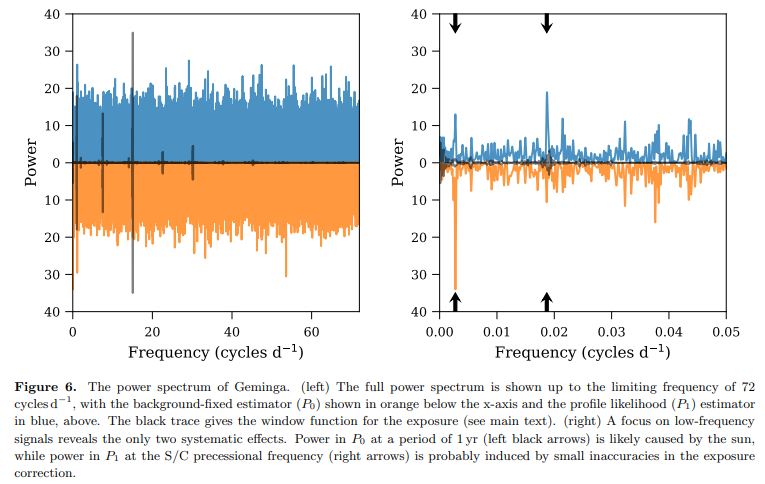

### LS 5039 
Fermi Orbital freq is 15.1 d-1, LS 5038 is 0.26/d.


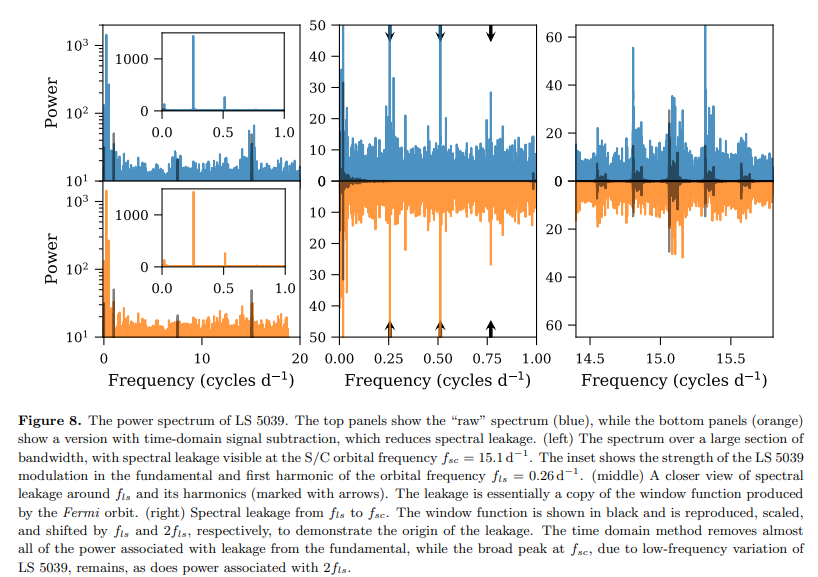

In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_data_man.ipynb.
Converted 02_effective_area.ipynb.
Converted 03_exposure.ipynb.
Converted 03_sources.ipynb.
Converted 04_load_data.ipynb.
Converted 04_simulation.ipynb.
Converted 04_skymaps.ipynb.
Converted 05_source_data.ipynb.
Converted 06_poisson.ipynb.
Converted 07_loglike.ipynb.
Converted 08_cell_data.ipynb.
Converted 09_lightcurve.ipynb.
Converted 10-time_series.ipynb.
Converted 14_bayesian.ipynb.
Converted 90_main.ipynb.
Converted 99_presentation.ipynb.
Converted 99_tutorial.ipynb.
Converted index.ipynb.
Sun Aug  7 10:51:12 PDT 2022
